# Customer Lifetime Value (CLV) Analysis and Prediction

## Project Overview
Customer Lifetime Value (CLV) represents the total future revenue expected from a customer based on historical purchasing behavior.  
This project analyzes transactional data to understand customer behavior, quantify churn impact, and model future customer value using RFM features and regression techniques.

## Business Problem
E-commerce businesses need to identify high-value customers and prioritize retention efforts.
However, customer churn and irregular purchase behavior make CLV prediction challenging.

## Objectives
- Analyze customer purchasing behavior
- Quantify churn in transactional data
- Engineer RFM features for CLV modeling
- Evaluate predictive limits of regression models
- Provide business-oriented insights and recommendations

## Dataset
Source: Online Retail Dataset

Each row represents a transaction and includes:
- Customer identifier
- Transaction date
- Purchase quantity and price
- Product and country information

## Data Loading
The dataset is loaded using pandas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("online_retail.csv")

## Initial Data Inspection
Examine data types, missing values, and overall structure to identify necessary cleaning steps.

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


## Data Cleaning
Key cleaning steps:
- Removed transactions without CustomerID (cannot assign CLV)
- Converted InvoiceDate to datetime
- Removed invalid transactions (negative quantities or prices)
- Created TotalPrice as Quantity × UnitPrice

In [7]:
df = df.dropna(subset=['CustomerID'])
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [9]:
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,397884.000000,397884,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,179.331775,NaN,22.097877,1713.141560


In [10]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3


## CLV Target Definition

Customer Lifetime Value (CLV) is defined as the total amount a customer spends
in a future time window. To avoid data leakage, a time-based split is applied.

- Past data → used to generate customer features
- Future data → used to compute CLV target

Random splits are inappropriate for CLV because future purchases must not influence past features.

In [11]:
cutoff_date = df['InvoiceDate'].max() - pd.DateOffset(months=2)

In [12]:
past_data = df[df['InvoiceDate']<= cutoff_date]
future_data = df[df['InvoiceDate']>cutoff_date]

In [13]:
print(df.shape)
print(past_data.shape)
print(future_data.shape)

(397884, 9)
(278886, 9)
(118998, 9)


## Feature Engineering — RFM Analysis

RFM features summarize customer purchasing behavior:
- Recency: Days since last purchase
- Frequency: Number of unique purchases
- Monetary: Total past spending

In [53]:
snapshot_date = cutoff_date

rfm =past_data.groupby('CustomerID').agg({
    'InvoiceDate':lambda x:(snapshot_date -x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID','Recency','Frequency','Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,264,1,77183.60
1,12347.0,68,5,2790.86
2,12348.0,13,4,1797.24
3,12350.0,248,1,334.40
4,12352.0,10,7,2194.31


## CLV Target Creation
The CLV target is calculated as the total future spending per customer.

In [15]:
clv_target =future_data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
clv_target.columns =['CustomerID','CLV']

## Dataset Assembly
RFM features are merged with the CLV target. Customers without future purchases
are assigned CLV = 0 to represent churn.

In [16]:
data = rfm.merge(clv_target, on='CustomerID', how='left')
data['CLV'] = data['CLV'].fillna(0)

In [17]:
data.describe()

,CustomerID,Recency,Frequency,Monetary,CLV
count,3710.000000,3710.000000,3710.000000,3710.000000,3710.000000
mean,15272.718598,92.970620,3.679245,1749.956284,558.151466
std,1721.026337,88.712917,6.262401,7298.507838,3635.470231
min,12346.000000,0.000000,1.000000,2.900000,0.000000
25%,13774.750000,18.000000,1.000000,289.352500,0.000000
50%,15248.000000,60.500000,2.000000,603.395000,0.000000
75%,16753.500000,150.000000,4.000000,1458.847500,460.725000
max,18287.000000,312.000000,145.000000,203948.190000,168469.600000


In [18]:
data.head()

,CustomerID,Recency,Frequency,Monetary,CLV
0,12346.0,264,1,77183.60,0.00
1,12347.0,68,5,2790.86,1519.14
2,12348.0,13,4,1797.24,0.00
3,12350.0,248,1,334.40,0.00
4,12352.0,10,7,2194.31,311.73


## Feature Distribution Analysis
Visualize distributions of RFM features to understand skewness and scale.

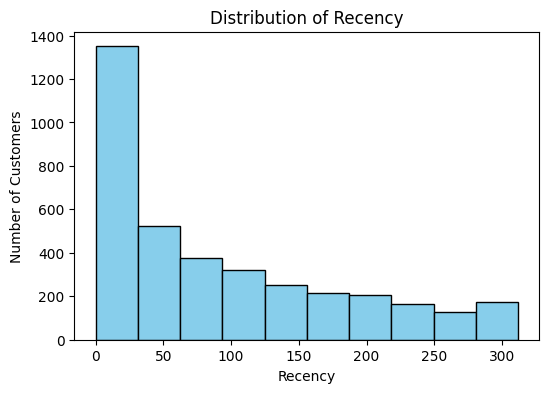

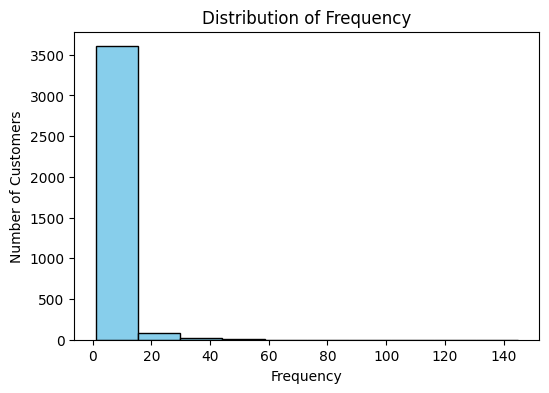

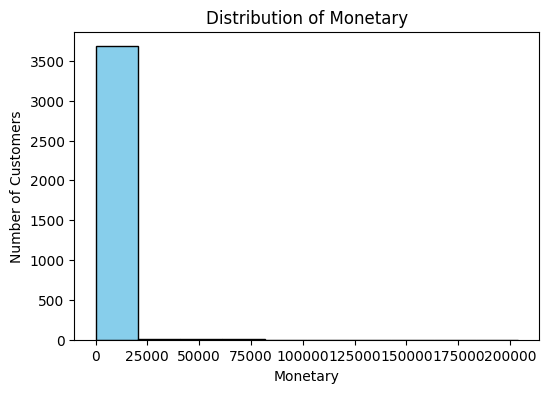

In [19]:
import matplotlib.pyplot as plt

features = ['Recency', 'Frequency', 'Monetary']

for col in features:
    plt.figure(figsize=(6,4))
    plt.hist(data[col], bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Number of Customers')
    plt.show()

## CLV Distribution and Churn Analysis

Check zero-CLV customers and visualize skewed target distribution.

In [20]:
zero_clv_count = (data['CLV'] == 0).sum()

total_customers = data.shape[0]

zero_percentage = (zero_clv_count / total_customers) * 100

zero_clv_count, total_customers, zero_percentage

(np.int64(1916), 3710, np.float64(51.644204851752015))

Approximately 51% of customers have zero future CLV, indicating potential churn.  
The CLV distribution is right-skewed: most customers have low-to-moderate future spend, while a few high-value customers dominate revenue.  



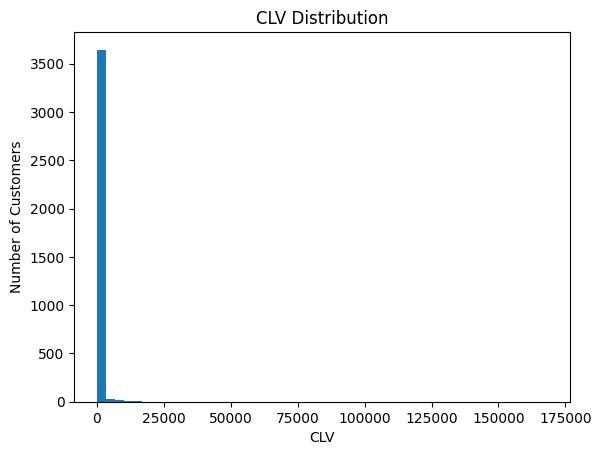

In [22]:
plt.hist(data['CLV'], bins=50)
plt.title("CLV Distribution")
plt.xlabel("CLV")
plt.ylabel("Number of Customers")
plt.show()

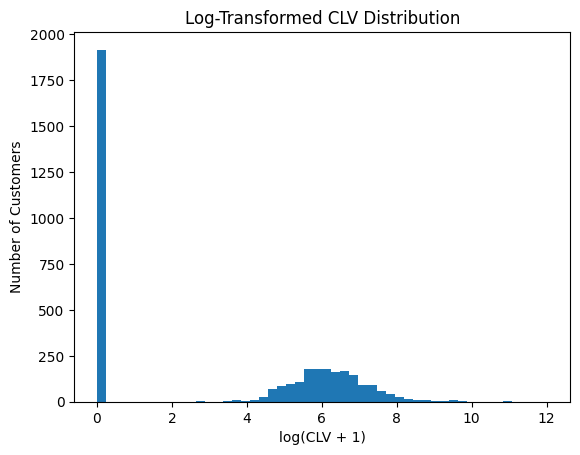

In [23]:
plt.hist(np.log1p(data['CLV']), bins=50)
plt.title("Log-Transformed CLV Distribution")
plt.xlabel("log(CLV + 1)")
plt.ylabel("Number of Customers")
plt.show()

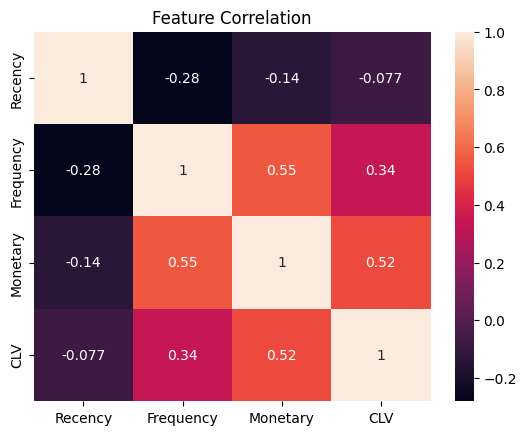

In [24]:
# Correlation Heatmap
sns.heatmap(data[['Recency','Frequency','Monetary','CLV']].corr(), annot=True)
plt.title("Feature Correlation")
plt.show()

### Insights

- CLV is highly right-skewed; log transformation (`log1p`) reduces extreme values, stabilizing regression.
- RFM features are correlated with CLV for non-zero customers, but cannot fully explain churn.
- A significant portion of customers have zero future CLV (≈51%), forming a distinct cluster; this presents a challenge for regression models.

## Train-Test Split
The dataset is split into training and testing sets to evaluate generalization.

In [25]:
from sklearn.model_selection import train_test_split

x = data[['Recency','Frequency','Monetary']]
y = data['CLV']

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size =0.2, random_state=42
)

- Split data into training (80%) and testing (20%) sets to evaluate model performance on unseen data.
- Features (x) are RFM metrics, and target (y) is CLV.
- Time-based split was already applied in feature engineering, so random splitting here is acceptable for evaluation.

##Model Building- Linear Regression (Baseline)

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

lr =LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [27]:
y_pred_lr = lr.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test,y_pred_lr)

print(f'Linear Regression → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')

Linear Regression → RMSE: 1037.42, MAE: 382.53, R2: 0.65


- RMSE: 1037.42 → average error magnitude in CLV units
- MAE: 382.53 → average absolute error
- R²: 0.65 → model explains ~65% of variance in CLV
- Baseline linear regression works reasonably well but may struggle with extreme CLV values and zero-cluster customers.

Visualizing Actual vs Predicted CLV:

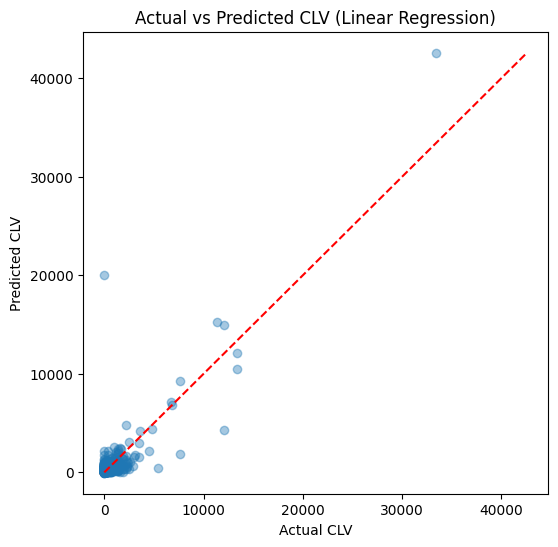

In [40]:
plt.figure(figsize=(6,6))

plt.scatter(
    y_test,
    y_pred_lr,
    alpha=0.4
)

# Perfect prediction line
max_val = max(y_test.max(), y_pred_lr.max())
plt.plot([0, max_val], [0, max_val], 'r--')

plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted CLV (Linear Regression)")

plt.show()

- Scatter plot shows predicted CLV vs actual CLV.
- Red dashed line = perfect predictions.
- Deviation from line highlights model error, especially for extreme CLV customers.

 ## Model Building — XGBoost

In [28]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Train
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [29]:
y_pred_xgb = xgb_model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test,y_pred_xgb)

print(f'XGBoost → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}')

XGBoost → RMSE: 1487.02, MAE: 440.25, R2: 0.28


- RMSE: 1487.02 → higher than linear regression
- MAE: 440.25 → slightly higher error
- R²: 0.28 → explains ~28% variance, worse than linear regression in this setup
- Possibly due to extreme CLV outliers and zero-CLV cluster affecting tree-based learning.

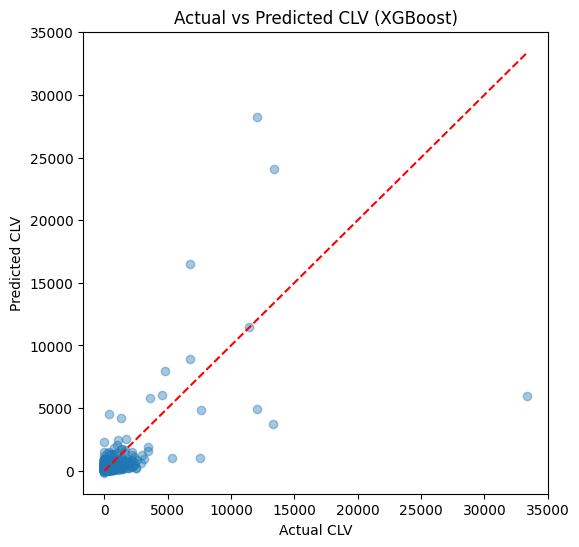

In [39]:
plt.figure(figsize=(6,6))

plt.scatter(
    y_test,
    y_pred_xgb,
    alpha=0.4
)

# Perfect prediction line
max_val = max(y_test.max(), y_pred_xgb.max())
plt.plot([0, max_val], [0, max_val], 'r--')

plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted CLV (XGBoost)")

plt.show()

- Similar scatter plot for predicted vs actual CLV.
- Highlights underprediction for high-value customers.

##Log Transformation of Target (Reduce Skewness)

In [30]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [31]:
lr_log =LinearRegression()
lr_log.fit(x_train,y_train_log)

LinearRegression()

In [32]:
xgb_model_log = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
xgb_model_log.fit(x_train,y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
y_pred_lr_log = np.expm1(lr_log.predict(x_test))
y_pred_xgb_log = np.expm1(xgb_model_log.predict(x_test))

- CLV is highly right-skewed → log transformation stabilizes extreme high values.
- log1p handles zero CLV values (log(0+1)=0).
- After predicting on log scale, use expm1 to convert back to original CLV scale.

Evaluation Function:

In [34]:
def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

In [37]:
evaluate(y_test,y_pred_lr_log)

{'MAE': 2960818222.8217306,
 'RMSE': np.float64(80649865815.84538),
 'R2': -2115607076818451.5}

In [38]:
evaluate(y_test,y_pred_xgb_log)

{'MAE': 368.4433858482744,
 'RMSE': np.float64(1249.656110174628),
 'R2': 0.4920642897885028}

- Linear Regression log-transformed fails dramatically for zeros → huge RMSE and negative R²
- XGBoost log-transformed performs better:
- MAE ~368
- RMSE ~1249
- R² ~0.49 → explains ~49% variance
- Indicates log-transform + XGBoost can handle skewness but zero-CLV customers remain a challenge.

##Visualization — Log Scale

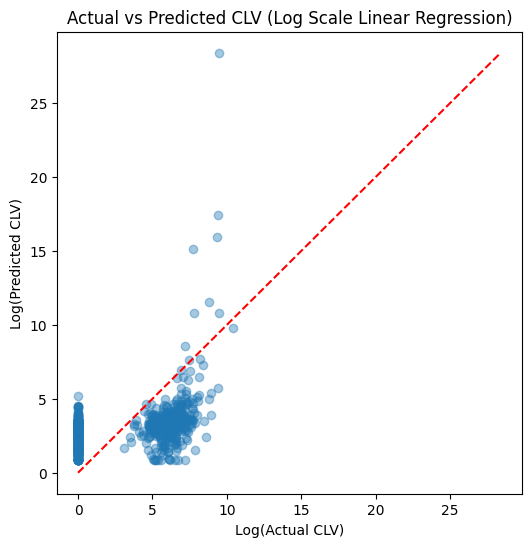

In [44]:
plt.figure(figsize=(6,6))

plt.scatter(
    np.log1p(y_test),
    np.log1p(y_pred_lr_log),
    alpha=0.4
)

max_val = max(np.log1p(y_test).max(), np.log1p(y_pred_lr_log).max())
plt.plot([0, max_val], [0, max_val], 'r--')

plt.xlabel("Log(Actual CLV)")
plt.ylabel("Log(Predicted CLV)")
plt.title("Actual vs Predicted CLV (Log Scale Linear Regression)")

plt.show()

In [47]:
y_pred_lr_log.max(), y_pred_lr_log.min()

(np.float64(2196876303437.6433), np.float64(1.2884667960297902))

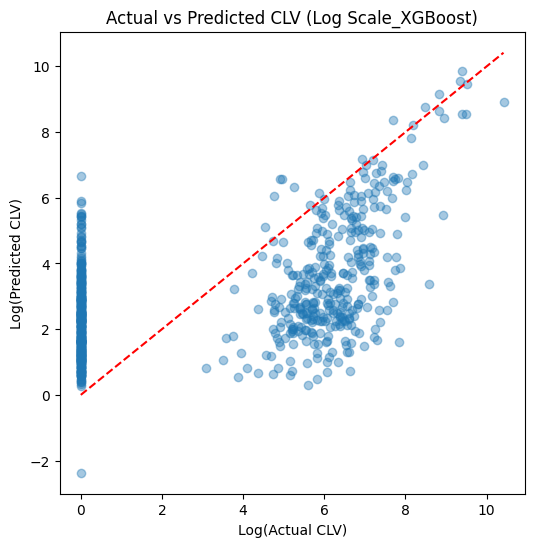

In [46]:
plt.figure(figsize=(6,6))

plt.scatter(
    np.log1p(y_test),
    np.log1p(y_pred_xgb_log),
    alpha=0.4
)

max_val = max(np.log1p(y_test).max(), np.log1p(y_pred_xgb_log).max())
plt.plot([0, max_val], [0, max_val], 'r--')

plt.xlabel("Log(Actual CLV)")
plt.ylabel("Log(Predicted CLV)")
plt.title("Actual vs Predicted CLV (Log Scale_XGBoost)")

plt.show()

- Log-scale plots show better alignment for mid-range CLV.
- Linear regression still predicts extreme values poorly.
- XGBoost handles skewed distribution better but cannot fully capture zero-CLV cluster.

##Save the Trained Model

- After training and evaluating the model, I save it to disk for later use in a web application.
- This avoids retraining the model every time the app is launched, saving computation time.
- I use joblib or pickle to serialize the XGBoost model.

In [54]:
import joblib

# Save the trained XGBoost model
joblib.dump(xgb_model_log, "xgb_clv_model.pkl")

# Save the feature columns (important for web app input consistency)
feature_columns = ['Recency', 'Frequency', 'Monetary']
joblib.dump(feature_columns, "feature_columns.pkl")

print("Model and feature columns saved successfully!")

Model and feature columns saved successfully!
